# Modelo de Regresión Múltiple

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

bd5 = bd5.withColumn('DepDelay2',(bd5.DepDelay**2)
).withColumn('DepD_Distance',(bd5.DepDelay * bd5.Distance)) 

## Descripción Previa de la Base de Datos

Resumen Numérico

In [3]:
pdf5 = bd5.sample(False, 0.1, 0).select('ArrDelay','DepDelay','DayOfWeek','CRSDepTime','DepDelay2','DepD_Distance').toPandas()
pdf5.corr()

,ArrDelay,DepDelay,DayOfWeek,CRSDepTime,DepDelay2,DepD_Distance
ArrDelay,1.000000,0.959762,0.055259,0.171944,0.750512,0.805307
DepDelay,0.959762,1.000000,0.052946,0.156121,0.795955,0.848215
DayOfWeek,0.055259,0.052946,1.000000,-0.022926,0.005808,0.043969
CRSDepTime,0.171944,0.156121,-0.022926,1.000000,0.068897,0.112791
DepDelay2,0.750512,0.795955,0.005808,0.068897,1.000000,0.747067
DepD_Distance,0.805307,0.848215,0.043969,0.112791,0.747067,1.000000


Configuración de la Base de Datos

In [4]:
from pyspark.ml.feature import VectorAssembler

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')
bd6 = a1.transform(bd5)

In [5]:
from pyspark.sql.functions import col

bd6 = bd6.select(col("ArrDelay").alias("label"),'features')
bd6.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| -7.0|[-5.0,1235.0,4.0,...|
| -3.0|[5.0,1235.0,5.0,8...|
| -3.0|[-3.0,1235.0,6.0,...|
| -2.0|[-7.0,1235.0,7.0,...|
| -2.0|[-6.0,1235.0,1.0,...|
|  0.0|[-1.0,1235.0,2.0,...|
| -6.0|(9,[1,2,3,5],[123...|
|  7.0|(9,[1,2,3,5],[123...|
| -9.0|[-1.0,1235.0,5.0,...|
| -2.0|[-1.0,1235.0,6.0,...|
| 13.0|[1.0,1235.0,7.0,8...|
|-16.0|[-2.0,1235.0,1.0,...|
|-21.0|[-4.0,1235.0,2.0,...|
|-16.0|[-1.0,1235.0,3.0,...|
|-11.0|(9,[1,2,3,5],[123...|
| -8.0|(9,[1,2,3,5],[123...|
| -4.0|[13.0,1235.0,6.0,...|
|  0.0|[17.0,1235.0,7.0,...|
| -2.0|[12.0,1235.0,1.0,...|
|  2.0|[19.0,1235.0,2.0,...|
+-----+--------------------+
only showing top 20 rows



## Ajuste del modelo

In [6]:
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

/usr/lib/spark/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [7]:
print(model.intercept,model.coefficients)

-4.635889634541887 [1.05553557286,-0.00289488941365,0.135668773288,0.00144922041931,-0.242298226852,1.62235576514,0.159579377181,-1.79458480022e-05,-2.10428631003e-05]


Modelo Predictivo:

$ Y_i = \beta_0 + \beta_1 X_{1i} + ... \beta_p X_{pi} $

In [8]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------------------+-------------------+-------------------+
|label|            features|         prediction|           residual|
+-----+--------------------+-------------------+-------------------+
| -7.0|[-5.0,1235.0,4.0,...| -9.969642778643822| 2.9696427786438218|
| -3.0|[5.0,1235.0,5.0,8...| 0.4615023639600766|-3.4615023639600766|
| -3.0|[-3.0,1235.0,6.0,...|  -7.63892282463571|   4.63892282463571|
| -2.0|[-7.0,1235.0,7.0,...| -11.62216243299346|   9.62216243299346|
| -2.0|[-6.0,1235.0,1.0,...|-11.406394139768883|  9.406394139768883|
|  0.0|[-1.0,1235.0,2.0,...| -6.122359077142607|  6.122359077142607|
| -6.0|(9,[1,2,3,5],[123...|-4.9571247210745675|-1.0428752789254325|
|  7.0|(9,[1,2,3,5],[123...| -4.821455947786069| 11.821455947786069|
| -9.0|[-1.0,1235.0,5.0,...|-5.7153527572771115|-3.2846472427228885|
| -2.0|[-1.0,1235.0,6.0,...|-5.5796839839886125| 3.5796839839886125|
| 13.0|[1.0,1235.0,7.0,8...|-3.3849199368370337| 16.384919936837033|
|-16.0|[-2.0,1235.0,1.0,...|-7.287

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="mae").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.340617652785411
10.60870150778019
0.9178062697891254


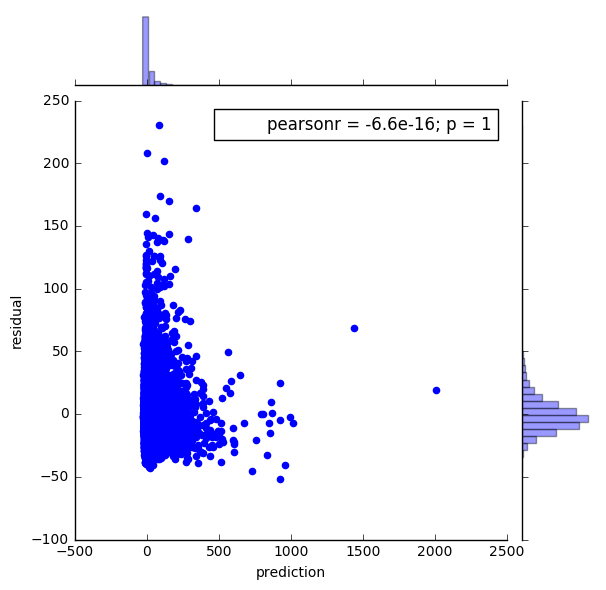

In [10]:
import seaborn as sns
%matplotlib inline

pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="residual", data=pdpred)